In [1]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset, Datastore
import pandas as pd
import numpy
import warnings
from datetime import datetime, timedelta
from azureml.datadrift import DataDriftDetector
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ws = Workspace.from_config()

dstore = Datastore.get(ws, 'workspaceblobstore')

df = pd.read_csv('data/loan_ds_clean.csv')

df.head()

df['date'] = pd.to_datetime(df['issue_d'])

print(f'Number of records in baseline: {len(df)}')

cutoff_date =  '2010-10-01'

df[df.date > cutoff_date]['emp_length'] = numpy.random.randint(0,20)

df[df.date > cutoff_date]['loan_amnt'] = df[df.date > cutoff_date]['loan_amnt'] * 1.5

df[df.date > cutoff_date]['annual_inc'] = df[df.date > cutoff_date]['annual_inc'] * 1.5

df[df.date > cutoff_date]['funded_amnt_inv'] = df[df.date > cutoff_date]['funded_amnt_inv'] * 2

df[df.date > cutoff_date]['int_rate'] = df[df.date > cutoff_date]['int_rate'] * 2

df.to_csv('data/loan_ds_clean.csv')

dstore.upload(src_dir='data', target_path='data', overwrite=True)

data_set = Dataset.Tabular.from_delimited_files((dstore, 'data/loan_ds_clean.csv'))

# convert to timseries dataset
data_set = data_set.with_timestamp_columns('date', validate=True)

# register the dataset
data_set = data_set.register(ws, name='loan_ds', create_new_version=True)

print('Target dataset registered!')

Number of records in baseline: 36294
Uploading an estimated of 6 files
Uploading data/.amlignore
Uploaded data/.amlignore, 1 files out of an estimated total of 6
Uploading data/.amlignore.amltmp
Uploaded data/.amlignore.amltmp, 2 files out of an estimated total of 6
Uploading data/house_pricing.csv
Uploaded data/house_pricing.csv, 3 files out of an estimated total of 6
Uploading data/house_pricing_target.csv
Uploaded data/house_pricing_target.csv, 4 files out of an estimated total of 6
Uploading data/loan_ds_clean.csv
Uploaded data/loan_ds_clean.csv, 5 files out of an estimated total of 6
Uploading data/loan_ds_target.csv
Uploaded data/loan_ds_target.csv, 6 files out of an estimated total of 6
Uploaded 6 files
Target dataset registered!


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [6]:
# Here we are going to divide the dataset into 2 parts - baseline and target based on cut off date.
data_set = Dataset.get_by_name(ws, 'loan_ds')

baseline_data_set = data_set.time_before(datetime(2010, 10, 1))

target_data_set = data_set.time_after(datetime(2010, 10, 1))

# set up data drift detector
monitor = DataDriftDetector.create_from_datasets(ws, 'loan-ds-drift-monitor', baseline_data_set, target_data_set, 
                                                      compute_target='worker-cpu', 
                                                      frequency='Day')



In [7]:
features = ['loan_amnt','emp_length', 'annual_inc', 'funded_amnt_inv', 'int_rate']

# get data drift detector by name
monitor = DataDriftDetector.get_by_name(ws, 'loan-ds-drift-monitor')

# update data drift detector
monitor = monitor.update(feature_list=features)

seed = datetime(2010, 10, 1)

backfill = any

# run a backfill for 12 months
for i in range(6):
    start_date = seed
    end_date = start_date + timedelta(days=30)
    seed = end_date
    backfill = monitor.backfill(start_date, end_date)
    i+=1

# make sure the backfill has completed
backfill.wait_for_completion(wait_post_processing=True)

# get results from Python SDK (wait for backfills or monitor runs to finish)
results, metrics = monitor.get_output(start_time=datetime(year=2010, month=10, day=1))

Current state: Disabled


{'loan-ds-drift-monitor': <Figure size 1440x576 with 2 Axes>}

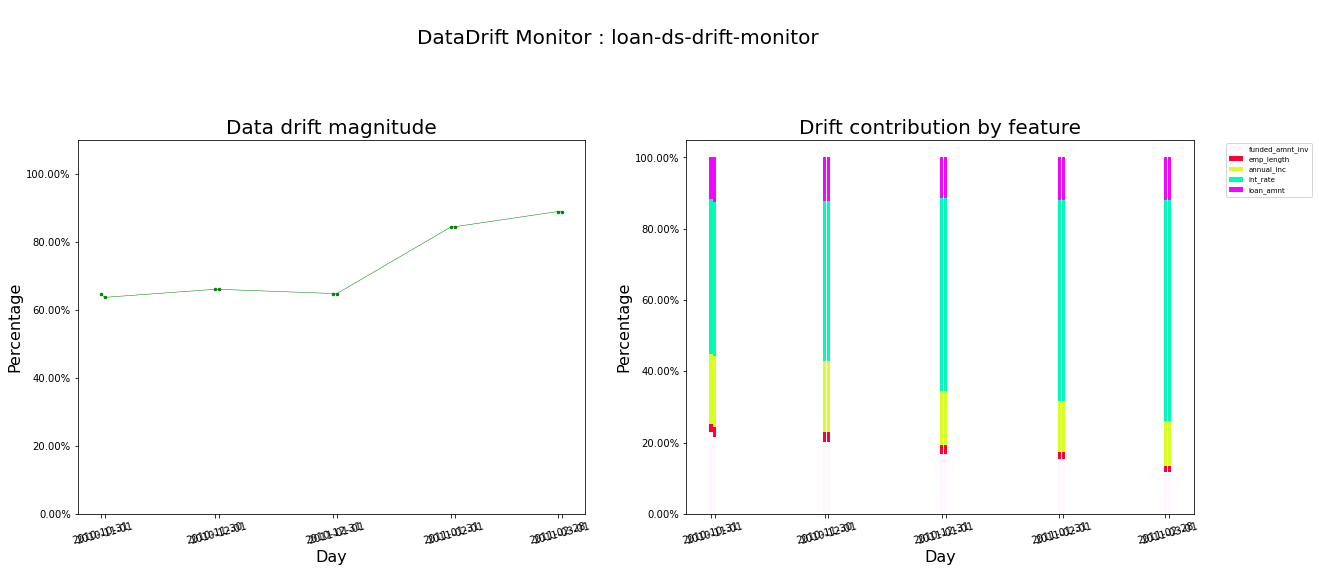

In [8]:
# plot the results from Python SDK 
monitor.show(datetime(2010, 10, 31), datetime(2011, 10, 30))

In [5]:
monitor = DataDriftDetector.get_by_name(ws, 'loan-ds-drift-monitor')
monitor.delete()

Current state: Deleting
.State transitioning completed, status: Deleted
